In [1]:
import numpy as np

from Solver import mesh_less, crank_nicolson_fd
from Utilz import F_v0, F_v0_x, diff, eval_F

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

In [2]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [3]:
def mu(x, t, prms):
    T = prms[0]
    sigma = prms[1]
    a = prms[2]
    v0 = prms[3]
    T_infty = prms[4]
    
    return T*T_infty/(a*(T_infty - T*t)) * (a/(2*T_infty) * (2*x-1) - v0)

In [4]:
def g(x, t, prms, max_k=20):
    T = prms[0]
    sigma = prms[1]
    a = prms[2]
    v0 = prms[3]
    T_infty = prms[4]
    
    sigma_hat = (T*T_infty*sigma**2)/(2*a**2*(T_infty-T))

    if t == 0:
        return 0
    elif np.isclose(mu(x, t, prms) - mu(0, 0, prms), 0):
        return 0
    else:
        return (mu(x, t, prms) - mu(0, 0, prms)) * F_v0_x(x, t, sigma_hat, mu(0, 0, prms), max_k)

# Convergence Rate & Model Behavior:

In [5]:
def eval_error(kappa, prms, mu, g, eps, n_points):
    ml_1 = mesh_less(kappa, prms, mu, g, theta=0.5, M=n_points[0], N=5, max_k=20, eps=eps)
    ml_2 = mesh_less(kappa, prms, mu, g, theta=0.5, M=n_points[1], N=5, max_k=20, eps=eps)
    ml_3 = mesh_less(kappa, prms, mu, g, theta=0.5, M=n_points[2], N=5, max_k=20, eps=eps)
    ml_4 = mesh_less(kappa, prms, mu, g, theta=0.5, M=n_points[3], N=5, max_k=20, eps=eps)
    ml_5 = mesh_less(kappa, prms, mu, g, theta=0.5, M=n_points[4], N=5, max_k=20, eps=eps)
    
    xx = np.linspace(0, 1, 20)
    
    err1 = np.sum((eval_F(ml_1, xx) - eval_F(ml_2, xx))**2)
    err2 = np.sum((eval_F(ml_2, xx) - eval_F(ml_3, xx))**2)
    err3 = np.sum((eval_F(ml_3, xx) - eval_F(ml_4, xx))**2)
    err4 = np.sum((eval_F(ml_4, xx) - eval_F(ml_5, xx))**2)
    
    err = np.array([err1, err2, err3, err4])
    
    return err

In [6]:
sigma = 1
a = 1.5
v0 = 1.1
T_infty = 2
T = 1

prms = [T, sigma, a, v0, T_infty]
kappa = (T*T_infty*sigma**2)/(2*a**2*(T_infty-T))

n_points = [4, 8, 16, 32, 64]
eps = [7, 9, 8]

err_eps1 = eval_error(kappa, prms, mu, g, eps[0], n_points)
err_eps2 = eval_error(kappa, prms, mu, g, eps[1], n_points)
err_eps3 = eval_error(kappa, prms, mu, g, eps[2], n_points)

In [7]:
M_ml = 9

xx = np.linspace(0, 1, 100)
TT = np.linspace(0.05, 1, 100)

F = np.zeros((len(TT), len(xx)))

for n in range(len(TT)):
    
    prms = [TT[n], sigma, a, v0, T_infty]
    kappa = (TT[n]*T_infty*sigma**2)/(2*a**2*(T_infty-TT[n]))
    
    ml = mesh_less(kappa, prms, mu, g, theta=0.5, M=M_ml, N=20, max_k=20)
    F[n, :] = eval_F(ml, xx) + F_v0(xx, 1, kappa, mu(0, 0, prms))

# Plotting:

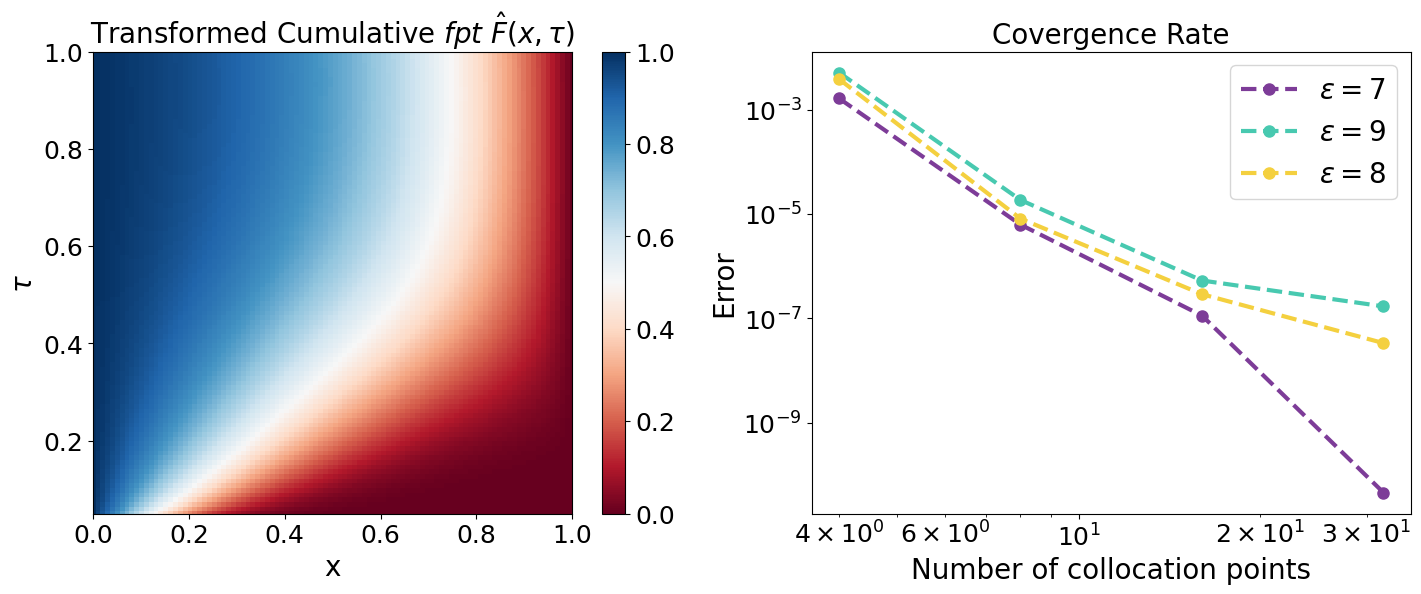

In [8]:
fig = plt.figure(figsize=(17, 6));
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
x, t = np.meshgrid(xx, TT)

c = ax0.pcolormesh(x, t, F, cmap='RdBu', vmin=F.min(), vmax=F.max())
ax0.set_title(r'Transformed Cumulative $fpt$ $\hat{F}(x, \tau)$')

ax0.axis([x.min(), x.max(), t.min(), t.max()])
fig.colorbar(c, ax=ax0)

plt.xlabel('x')
plt.ylabel(r'$\tau$')

ax1 = fig.add_subplot(gs[0, 1])
plt.loglog(n_points[:-1], err_eps1[:], '--o', linewidth=3, markersize=8, c='#7D3C98', label=r'$\epsilon={}$'.format(eps[0]));
plt.loglog(n_points[:-1], err_eps2[:], '--o', linewidth=3, markersize=8, c='#48C9B0', label=r'$\epsilon={}$'.format(eps[1]));
plt.loglog(n_points[:-1], err_eps3[:], '--o', linewidth=3, markersize=8, c='#F4D03F', label=r'$\epsilon={}$'.format(eps[2]));

plt.xlabel('Number of collocation points');
plt.ylabel('Error');
plt.title('Covergence Rate');
plt.legend();

plt.savefig('_plots/LC.png')
plt.savefig('_plots/LC.pdf')